# manoalga.lt Scraper

**Task:** Extract salary information for positions from page https://www.manoalga.lt by scraping it.

# 1. Analysis

## 1.1. Navigation and data

- Navigate to https://www.manoalga.lt
- Click "Salaries by positions". A list of position categories opens. URL example: https://www.manoalga.lt/en/salaryinfo
- Click on any of the categories. A list of category positions opens. Also we can see salary 1st and 10th percentile salary information for the category. URL example: https://www.manoalga.lt/en/salaryinfo/administration
- Click on any of the positions. Page with 1st and 10th percentile salary for selected position opens. URL example: https://www.manoalga.lt/en/salaryinfo/administration/administrative-worker

We will scrape categories, category 1st and 10th percentile salaries, positions and positon 1st and 10th percentile salaries.

## 1.2. Inspect the data extraction options

For page inspection, we will be using Chrome browser and its functions "Inspect" and "View page source".

First of all we need to check if data can be retrieved directly through some backend API that returns data in JSON format. This can be checked by looking through the network activity. 

Typically, this will show up if we filter to XHR. And if we look at the response, we will see clearly formatted JSON data. Example:
<div> 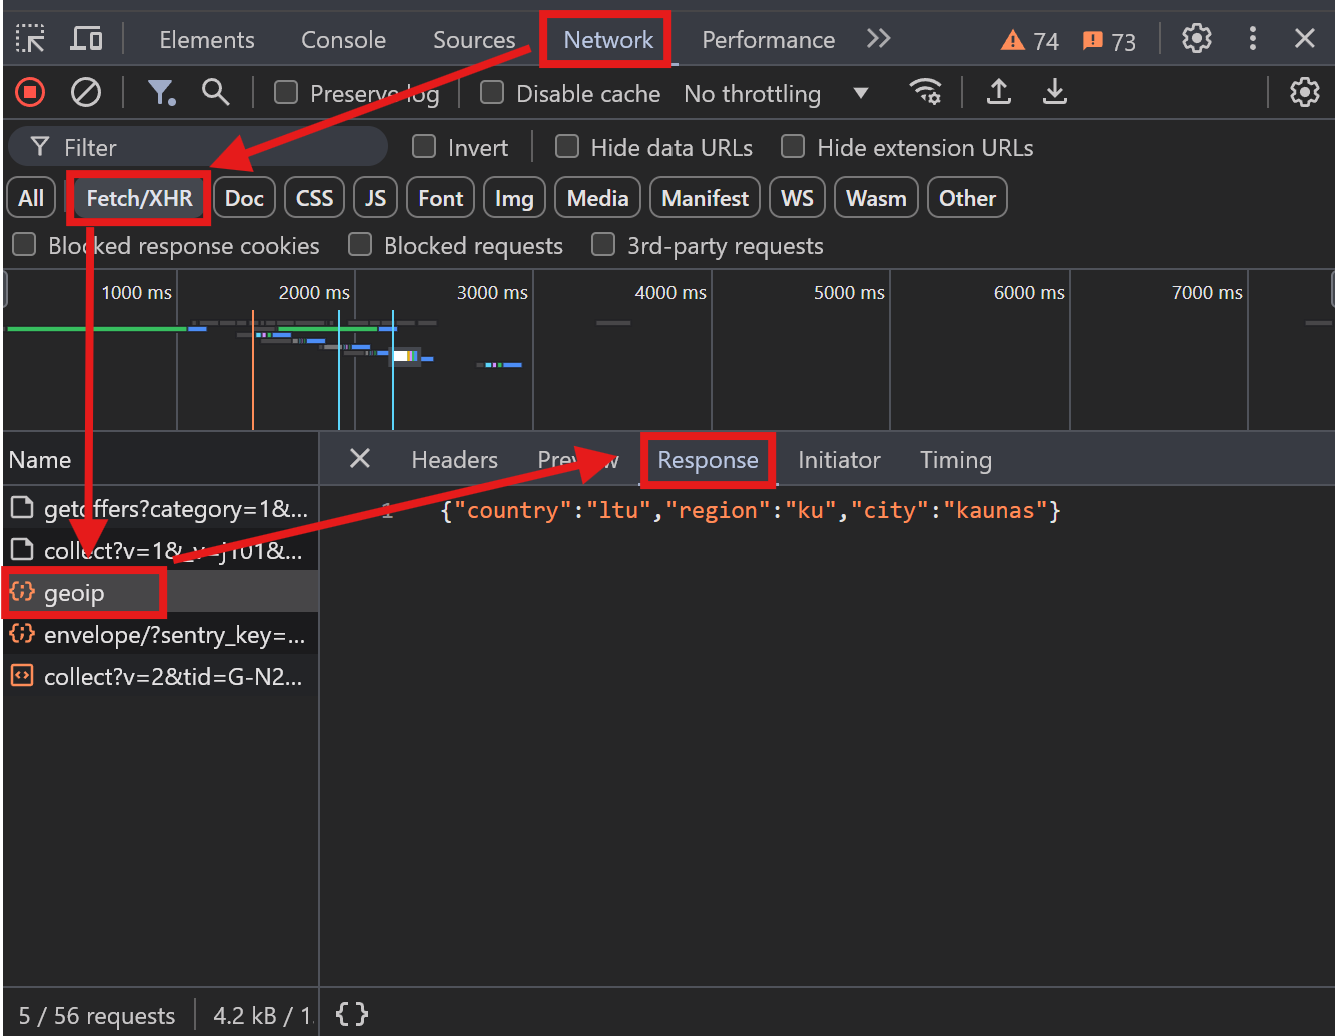</div> 

Next thing we can look for is JSON formatted data that is embedded in the HTML data. We can do that using browser function "View page source". Then, scroll down and check JSON formatted structure in opened window. 

Unfortuanately, these are not the cases with this project. 

In our case, our required data are displayed as static data in web page, so we can perform static scraping and Beutiful Soup library to parse HTML code for data extraction.


## 1.3. Identifying page structure

By analizing URLs we can see, that it has tree structure:
- https://www.manoalga.lt/en/salaryinfo - list of categories
- https://www.manoalga.lt/en/salaryinfo/administration - list of positions for category and category 1st and 10th percentile salary information
- https://www.manoalga.lt/en/salaryinfo/administration/administrative-worker - position information

Information for all lists can be identified with tag `<a>` which has attribute `class="category-full"`.
Salary informationcan be identified with tag `<span>` which has attribute `class="value"`

# 2. Scraper functions

In [1]:
# Import required modules
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep

In [2]:
# Function to request the raw html and check if request is valid
def get_response(url):
    try:
        response = requests.get(url)
        if response.status_code != 200:
            return None
    except response.exceptions.ConnectionError:
        return None

    return response   

In [3]:
# Function extacts list of categories from the page. Returns list of dictionaries.
def extract_categories():
    categories_url = 'https://www.manoalga.lt/en/salaryinfo'
    response_categories = get_response(categories_url)
    if response_categories == None:
        return []

    # parse the html and extract categories data
    categories = extract_group_items(response_categories)

    return categories

Example of function "extract_categories" returned list of dictionary:
```
[
    {
        'name': 'Administration',
        'url': 'https://www.manoalga.lt/en/salaryinfo/administration'
    },
    {
        'name': 'Agriculture, Food Industry',
        'url': 'https://www.manoalga.lt/en/salaryinfo/agriculture-food-industry'
    }
]

In [4]:
#Function for 1st and 10th percentile salary and position list extraction for a category, using its information URl. Returns dictionary.
def extract_category_info(category_url):
    response_category = get_response(category_url)

    category_info = extract_salary(response_category)
    positions = extract_group_items(response_category)
    
    category_info['positions'] = positions
    return category_info

Example of function "extract_category_info" returned dictionary:

```
{
    '10%_salary': 884.0,
    '90%_salary': 2120.0,
    'positions': 
        [
            {
                'name': 'Administrative Worker',
                'url': 'https://www.manoalga.lt/en/salaryinfo/administration/administrative-worker'
            },
            {
                'name': 'Archivist, Registry Administrator',
                'url': 'https://www.manoalga.lt/en/salaryinfo/administration/archivist-registry-administrator'
            }
        ]
}

In [5]:
#Since the category and position lists has the same structure in the page, we can use the same function for both.
#Function parses HTML code to get either category or position name and its URL. Returns list of dictionaries.
def extract_group_items(response):
    soup = BeautifulSoup(response.text, 'html.parser')
    item_soup = soup.find_all("a", class_="category-full")

    items = []
    for i in item_soup:
        if i:
            name = i.find('h3').get_text()
            url = i.get('href')
            items.append({'name': name, 'url': url})
    return items

Example of function "extract_group_items" returned list of dictionary:

```
[
    {
        'name': 'Administration',
        'url': 'https://www.manoalga.lt/en/salaryinfo/administration'
    },
    {
        'name': 'Agriculture, Food Industry',
        'url': 'https://www.manoalga.lt/en/salaryinfo/agriculture-food-industry'
    }
]

In [6]:
#Function parses HTML code to get 1st and 10th percentile salary values. Reruns dictionary.
def extract_salary(response):
    soup = BeautifulSoup(response.text, 'html.parser')
    salary_range = soup.find_all("span", class_="value")
    if len(salary_range) == 2:
        salary_10 = salary_range[0].get('data-monthly-value')
        salary_90 = salary_range[1].get('data-monthly-value')
        return {'10%_salary': float(salary_min), '90%_salary': float(salary_90)}
    return{}

Example of function "extract_salary" returned dictionary:
```
{
    '10%_salary': 884.0, 
    '90%_salary': 2120.0
}

In [7]:
# Main data scraper function, which runs previously defined functions in right order, gets data in the list of dictionaries and saves it to file.
# Added delay of 0.5 second to avoid overloading servers and triggering anti-scraping measures. It allows to mimic human behavior, making scraper 
# less detectable.

def main():
    categories = extract_categories()
    
    positions = []
    for category_index, category in enumerate(categories):
        category_info = extract_category_info(category['url'])
        for position_index, position in enumerate(category_info.get('positions')):
            position_salary = extract_salary(get_response(position['url']))
            positions.append({
                                'position_name': position['name'],
                                'position_url': position['url'],
                                'position_10%_salary': position_salary.get('10%_salary'),
                                'position_90%_salary': position_salary.get('90%_salary'),
                                'category_name': category['name'],
                                'category_url': category['url'],
                                'category_10%_salary': category_info.get('10%_salary'),
                                'category_90%_salary': category_info.get('90%_salary'),
                            })
            sleep(0.5)
        sleep(0.5)
    
    pd.DataFrame(positions).to_csv('position_list.csv', index=False)

In [8]:
# To run scraper, we need to uncomment and run main function. This function takes some time to run.
# main()

In [9]:
position_list = pd.read_csv('position_list.csv')
position_list.describe()

,position_10%_salary,position_90%_salary,category_10%_salary,category_90%_salary
count,601.000000,601.000000,665.000000,665.000000
mean,1033.782174,2755.220096,1024.559398,2690.521805
std,280.429840,1076.059556,167.925507,672.340098
min,570.000000,1158.000000,543.000000,1511.000000
25%,835.644297,2014.000000,916.000000,2256.000000
50%,985.000000,2442.225920,980.000000,2444.000000
75%,1168.000000,3237.000000,1065.000000,2886.000000
max,2420.000000,8879.000000,1351.000000,4702.000000


In [10]:
position_list['position_salary_range'] = position_list['position_90%_salary'] - position_list['position_10%_salary']
position_list['category_salary_range'] = position_list['category_90%_salary'] - position_list['category_10%_salary']
position_list['position_salary_average'] = (position_list['position_90%_salary'] + position_list['position_10%_salary'])/2
position_list['category_salary_average'] = (position_list['category_90%_salary'] + position_list['category_10%_salary'])/2
position_list.head(5)

,position_name,position_url,position_10%_salary,position_90%_salary,category_name,category_url,category_10%_salary,category_90%_salary,position_salary_range,category_salary_range,position_salary_average,category_salary_average
0,Administrative Worker,https://www.manoalga.lt/en/salaryinfo/administ...,848.0,1997.0,Administration,https://www.manoalga.lt/en/salaryinfo/administ...,884.0,2120.0,1149.0,1236.0,1422.5,1502.0
1,"Archivist, Registry Administrator",https://www.manoalga.lt/en/salaryinfo/administ...,805.0,1833.0,Administration,https://www.manoalga.lt/en/salaryinfo/administ...,884.0,2120.0,1028.0,1236.0,1319.0,1502.0
2,Assistant,https://www.manoalga.lt/en/salaryinfo/administ...,869.0,1846.0,Administration,https://www.manoalga.lt/en/salaryinfo/administ...,884.0,2120.0,977.0,1236.0,1357.5,1502.0
3,CSR specialist,https://www.manoalga.lt/en/salaryinfo/administ...,570.0,4625.0,Administration,https://www.manoalga.lt/en/salaryinfo/administ...,884.0,2120.0,4055.0,1236.0,2597.5,1502.0
4,Call Operator,https://www.manoalga.lt/en/salaryinfo/administ...,733.0,1804.0,Administration,https://www.manoalga.lt/en/salaryinfo/administ...,884.0,2120.0,1071.0,1236.0,1268.5,1502.0


<Axes: ylabel='Frequency'>

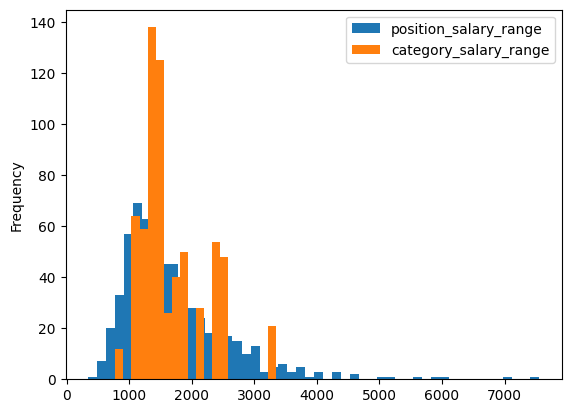

In [43]:
position_list['position_salary_range'].plot(kind='hist', bins=50, legend={'Position salary range'})
# plt.xlabel('Position salary range')
position_list['category_salary_range'].plot(kind='hist', bins=20, legend={'Position salary range'})
# plt.xlabel('Category salary range')